## Preamble: Libs + signal def

In [1]:
import itertools, importlib, sys, warnings, os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
from tensorflow.python import debug as tf_debug
print("Tensorflow version:", tf.__version__)

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
import embodied_arch.embodied_central_Qcritic as emac
importlib.reload(emac)

from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate
from embodied_arch.embodied_central_Qcritic import QsaNetwork

In [3]:
sys.path.append('./minoritygame')
import minoritygame.minority_multienv as MGME
importlib.reload(MGME) 


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

log_path = './log/mingame'

## Setup k-vs-(N-k) Mingame Env

In [4]:
importlib.reload(MGME)

# n_agents = 61
# exos = (np.random.sample(n_agents) < 0.3)  # np.sum(exos)
# exos = [True, True, False, False, False, True]  # Majority subpop
# exos = [True, True, False, False, False, False]  # Minority subpop

exos = [True, True, False, False, False]  # Minority subpop
menv = MGME.MinorityGame_Multiagent_env(
    m=3, s=4,
    exo_actorsQ=exos
)

print(len(menv.actor_exoQ), menv.actor_count, menv.actor_index)
print(menv.state_space_size, menv.action_space_size)

5 2 [0, 1]
3 1


## Setup MARL

In [5]:
# num_episodes, n_epochs, max_len = (100, 601, 251)
num_episodes, n_epochs, max_len = (100, 751, 150)

In [6]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(32,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(16,8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(
    st, hSeq=(16,8,), 
    out_dim=out_dim, gamma_reg=5.
)

qsa = lambda sts, ats: QsaNetwork(
    sts, ats, 
    hSeq=(16,16,8,), gamma_reg=2.
)

In [7]:
tf.reset_default_graph()
importlib.reload(emac)

<module 'embodied_arch.embodied_central_Qcritic' from '/Users/oosoba/Documents/RAND/Coding/multiagent-ABM/embodied_arch/embodied_central_Qcritic.py'>

In [8]:
empopn = emac.EmbodiedAgent_MAC(
    name="mgMAC_k-vs-N-k", env_=menv, 
    alpha_p=50., alpha_v=12., alpha_q=3.,
    actorNN=actor, valueNN=value,
    latentDim=12, sensorium=sensor, QNN=qsa,
    max_episode_length=max_len,
    _every_=150, CyclicSchedule=None #("log", 150)  #("exp", 150) #None #("log", 50)
)

In [9]:
# empopn = emac.EmbodiedAgent_MAC( 
#     name=agent_name,
#     env_=MinorityGame_Multiagent_env,
#     latentDim=_zdim_,
#     space_size=(_s_size_, _a_size_),
#     sensorium=SensoriumNetworkTemplate,
#     actorNN=ActionPolicyNetwork,
#     valueNN=ValueNetwork,
#     QNN=QsaNetwork,
#     alpha_p=5e-2, alpha_v=1e-1, alpha_q=1e-1,
#     _every_=_every_, recover=None,
#     max_episode_length=_max_len_
# )

# print(empopn, empopn.s_size, empopn.a_size)

In [10]:
sess = tf.InteractiveSession()
# sess = tf_debug.LocalCLIDebugWrapperSession(sess)

empopn.init_graph(sess)  # note tboard log dir

Tensorboard logs in:  ./log/train_mgMAC_k-vs-N-k


In [11]:
## Verify step + play set up
state = empopn.env.reset()
# print(state, empopn.act(state, sess))

empopn.play(sess)
np.sum(np.array(empopn.episode_buffer['rewards']), axis=0)
# np.array(empopn.episode_buffer['rewards'])

array([66., 64.])

In [12]:
print(empopn.last_total_returns/max_len)
print(emac.summarize_np(empopn.last_total_returns))

[0.44       0.42666667]
(64.0, 65.0, 66.0)


### Pre-test Agent

In [13]:
print('Baselining untrained pnet...')
rwd_mg0 = []
for k in range(num_episodes):
    empopn.play(sess, terminal_reward=0.)
    rwd_mg0.append(empopn.last_total_returns)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
base_perf_mg = 100.*np.mean(np.array(rwd_mg0)/float(empopn.max_episode_length), axis=0)
print("\nAgents win an average of {} pct".format(base_perf_mg))

base_per_agent = 100.*np.mean(np.array(rwd_mg0)/float(empopn.max_episode_length), axis=0)

Baselining untrained pnet...
Episode 80/100
Agents win an average of [38.52666667 37.70666667] pct


## Train MARL Agents

	 Iteration 299: Q loss([5.944254  6.3616047])])

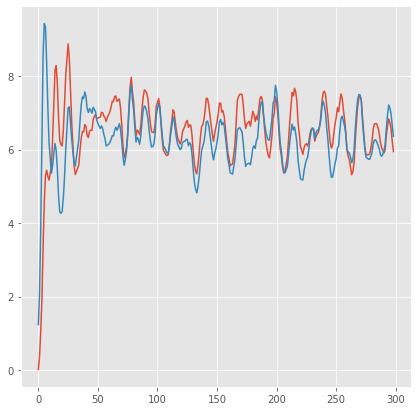

In [14]:
obs = []
for ct in range(300): #(1250):
    empopn.play(sess)
    tmp = empopn.train_eval_QC(sess)
    obs.append(np.mean(tmp, axis=0))
    print('\r\t Iteration {}: Q loss({})'.format(ct, np.mean(tmp, axis=0)), end="")
plt.plot(obs[1:]);

In [15]:
# ### Train Agent w/ Algo on Experience Tuples
# Train pnet on mingame episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=0)
hist = empopn.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent mgMAC_k-vs-N-k
Epoch no.: 0/751

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (48.0, 50.0, 52.0)
Losses/Policy LLs: (-1.3765862, -0.6268907, -0.29093915)
Losses/Policy Entropies: (0.5649987, 0.61371326, 0.6717731)
Values/Critic Scores: (1.7756317, 1.9705316, 2.5000117)
Values/Mean Q Scores: (6.25841, 6.4573474, 6.656285)
Saved Model
Epoch no.: 106/751Model issues @Step 106. Stats(['Perf/Recent Rewards', 'Losses/Policy LLs', 'Losses/Policy Entropies', 'Values/Critic Scores', 'Values/Mean Q Scores']): ( [(14.0, 24.5, 35.0), (-9.626077, -0.30856368, -3.0086604e-09), (0.002, nan, 0.5775532), (-0.73818105, 0.42750505, 1.5671607), (16.493713, 17.307749, 18.121784)] )

Restored Last Good Model:  ./log/train_mgMAC_k-vs-N-k/model-0.cptk
Epoch no.: 150/751

	Stats @Step 150: 	(Min, Mean, Max)
Perf/Recent Rewards: (44.0, 45.0, 46.0)
Losses/Policy LLs: (-2.1932573, -0.43291727, -0.11828007)
Losses/Policy Entropies: (0.34974957, 0.4023534, 0.4549575)
Values/Crit

### Post-test Agent

In [16]:
# Test pnet!
print('Testing...')
rwd_mg = []
for k in range(num_episodes):
    empopn.play(sess, terminal_reward=0.)
    rwd_mg.append(empopn.last_total_returns)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
trained_perf_mg = 100.*np.mean(np.array(rwd_mg)/float(empopn.max_episode_length), axis=0)
print("\nAgent wins an average of {} pct compared to baseline of {} pct".format(
    trained_perf_mg, base_perf_mg) )

trained_per_agent = 100.*np.mean(np.array(rwd_mg)/float(empopn.max_episode_length), axis=0)

Testing...
Episode 80/100
Agent wins an average of [50.04       49.84666667] pct compared to baseline of [38.52666667 37.70666667] pct



Agent wins an average of [50.04       49.84666667] pct 
compared to baseline of [38.52666667 37.70666667] pct


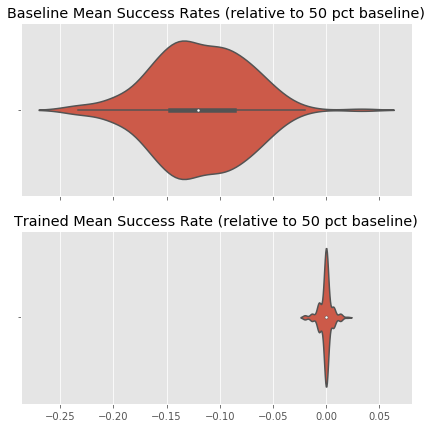

In [17]:
fig, axs = plt.subplots(2, 1, sharex=True)
sns.violinplot(np.array(rwd_mg0)/empopn.max_episode_length - 0.5, ax = axs[0])
axs[0].set_title('Baseline Mean Success Rates (relative to 50 pct baseline)')
sns.violinplot(np.array(rwd_mg)/empopn.max_episode_length - 0.5, ax = axs[1])
axs[1].set_title('Trained Mean Success Rate (relative to 50 pct baseline)')

print("\nAgent wins an average of {} pct \ncompared to baseline of {} pct".format(
    trained_perf_mg, base_perf_mg) )

Text(0.5, 0, 'Agent Index')

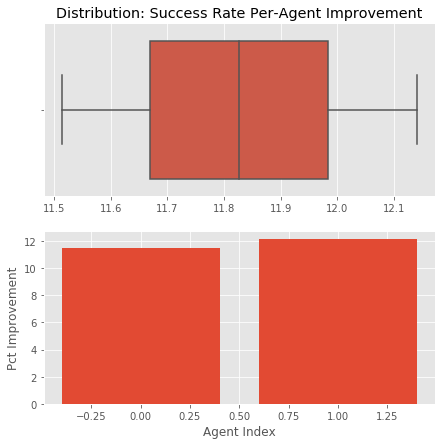

In [18]:
fig, axs = plt.subplots(2,1)
cmp = sns.boxplot(trained_per_agent-base_per_agent, ax = axs[0])
axs[0].set_title('Distribution: Success Rate Per-Agent Improvement');
axs[1].bar(x=range(sum(exos)), height=(trained_per_agent-base_per_agent))
axs[1].set_ylabel('Pct Improvement')
axs[1].set_xlabel('Agent Index')